In [1]:
import os
import numpy as np

import torch
torch.manual_seed(29)
from torch import nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
from torch.utils.data import DataLoader

from torchstat import stat
from utils import  models
from utils.data import dataset_1
from utils.trainer_utils import parfilter

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from skimage.measure import compare_psnr, compare_ssim

In [2]:
def image_quality_comp(I, Iout, Enout):
    
    for x in ['test.png', 'test_35.jpg', 'test.flif', 'test1.png', 'test1.flif', 'test_comp.png']: 
        if os.path.exists(x):os.remove(x)
    
    I.save('test.png')
    Iout.save('test_comp.png')
    I.save('test_35.jpg', quality = 35)
    Enout.save('test1.png')
    
    os.system("flif -e test.png test.flif")
    os.system("flif -e test1.png test1.flif")
    
    print('Original Image :: ')
    print('PNG     :: ' + str(os.path.getsize('test.png')/(I.size[0] * I.size[1])))
    print('JPG-35% :: ' + str(os.path.getsize('test_35.jpg')/(I.size[0] * I.size[1])))
    print('FLIF    :: ' + str(os.path.getsize('test.flif')/(I.size[0] * I.size[1])))
    print('Encoded Image :: ')
    print('PNG     :: ' + str(os.path.getsize('test1.png')/(I.size[0] * I.size[1])))
    print('FLIF    :: ' + str(os.path.getsize('test1.flif')/(I.size[0] * I.size[1])))

In [18]:
def perform_compression(I_org, model):
    
    w, h = I_org.size
    I = I_org.crop((0, 0, 256*(int(np.ceil(w/256))), 256*(np.ceil(h/256))))
    
    s_ = 256
    d_ = 64
    
    I1 = np.float32(I)#[:256, :256, :]
    I1 = np.transpose(I1, [2, 0, 1])
    Iout = np.zeros_like(I1)
    Enout = np.zeros((3, I1.shape[1]//4, I1.shape[2]//4))
    for i in range(0, I1.shape[1], s_):
        for j in range(0, I1.shape[2], s_):
            It = torch.from_numpy(np.expand_dims(I1[:, i:i+s_, j:j+s_], 0))/255.0
            X = model(It)
            Iout[:, i:i+s_, j:j+s_] = np.clip(X.data.squeeze().cpu().numpy(), 0, 1)
            Xe = model.encode(It)
            Xe = (Xe + 1)/2
            Enout[:, i//4:(i+s_)//4, j//4:(j+s_)//4] = Xe.data.squeeze().cpu().numpy()
    
    
    Iout = np.uint8(255 * Iout.transpose([1, 2, 0]))
    Enout = np.uint8(255 * Enout.transpose([1, 2, 0]))
    
    Iout = Image.fromarray(Iout).crop((0, 0, w, h))
    Enout = Image.fromarray(Enout)
    
    psnr = compare_psnr(np.uint8(I_org).copy(), np.uint8(Iout).copy())
#     ssim = compare_ssim(np.uint8(I_org).copy(), np.uint8(Iout).copy())
    
    print('PSNR-PROP :: ' + "{0:0.02f}".format(psnr))
#     print('SSIM-PROP :: ' + "{0:0.02f}".format(ssim), multichannel=True)
    
    psnr = compare_psnr(np.uint8(I_org).copy(), np.uint8(Image.open('test_35.jpg')).copy())
    print('PSNR-JPG35 :: ' + "{0:0.02f}".format(psnr))
    
    image_quality_comp(I_org, Iout, Enout)
    
    return Iout, Enout

In [17]:
def perform_compression2(I_org, model):
    
    w, h = I_org.size
    I = I_org.crop((0, 0, 256*(int(np.ceil(w/256))), 256*(np.ceil(h/256))))
    
    s_ = 256
    d_ = 64
    
    I1 = np.float32(I)#[:256, :256, :]
    I1 = np.transpose(I1, [2, 0, 1])
    Iout = np.zeros_like(I1)
    Enout = np.zeros((I1.shape[1]//2, I1.shape[2]//2))
    for i in range(0, I1.shape[1], s_):
        for j in range(0, I1.shape[2], s_):
            It = torch.from_numpy(np.expand_dims(I1[:, i:i+s_, j:j+s_], 0))/255.0
            X = model(It)
            Iout[:, i:i+s_, j:j+s_] = np.clip(X.data.squeeze().cpu().numpy(), 0, 1)
            Xe = model.encode(It)
            Xe = nn.functional.pixel_shuffle((Xe + 1)/2, 2)
            Enout[i//2:(i+s_)//2, j//2:(j+s_)//2] = Xe.data.squeeze().cpu().numpy()
    
    
    Iout = np.uint8(255 * Iout.transpose([1, 2, 0]))
    Enout = np.uint8(255 * Enout)
    
    Iout = Image.fromarray(Iout).crop((0, 0, w, h))
    Enout = Image.fromarray(Enout)
    
    psnr = compare_psnr(np.uint8(I_org).copy(), np.uint8(Iout).copy())
#     ssim = compare_ssim(np.uint8(I_org).copy(), np.uint8(Iout).copy(), multichannel=True)
    
    print('PSNR-PROP :: ' + "{0:0.02f}".format(psnr))
#     print('SSIM-PROP :: ' + "{0:0.02f}".format(ssim))
    
    psnr = compare_psnr(np.uint8(I_org).copy(), np.uint8(Image.open('test_35.jpg')).copy())
    print('PSNR-JPG35 :: ' + "{0:0.02f}".format(psnr))
    
    image_quality_comp(I_org, Iout, Enout)
    
    return Iout, Enout

In [5]:
img_file = "/media/narsi/LargeData/DATASETS/superrez/clic_2019/professional_valid/valid/alberto-montalesi-176097.png"

In [6]:
I = Image.open(img_file).convert("RGB")

In [7]:
model = models.QuantACTShuffleV3()
check_point_file = "/media/narsi/LargeData/SP_2020/compressACT/weights/QuantACTShuffleV3_exp02/model_best.pth.tar"
checkpoint = torch.load(check_point_file)
model.load_state_dict(checkpoint['state_dict'], strict = False)

<All keys matched successfully>

In [8]:
M = models.QuantACTShuffleV3()
check_point_file = "/media/narsi/LargeData/SP_2020/compressACT/weights/QuantACTShuffleV3_exp02/model_best.pth.tar"
checkpoint = torch.load(check_point_file)
M.load_state_dict(checkpoint['state_dict'], strict = False)

model = models.CleanImg(M)
check_point_file = "/media/narsi/LargeData/SP_2020/compressACT/weights/CleanImg_exp01/model_best.pth.tar"
checkpoint = torch.load(check_point_file)
model.load_state_dict(checkpoint['state_dict'], strict = False)

<All keys matched successfully>

In [19]:
Iout, Enout = perform_compression(I, model)

PSNR-PROP :: 34.94
PSNR-JPG35 :: 34.73
Original Image :: 
PNG     :: 1.5242399578136463
JPG-35% :: 0.04184280138022744
FLIF    :: 1.3481101402008437
Encoded Image :: 
PNG     :: 0.10036633632153338
FLIF    :: 0.08965853987068965


In [23]:
compare_ssim(np.uint8(I).copy(), np.uint8(Iout).copy(), multichannel=True, data_range = 255.0)

0.8655447198742507

In [10]:
from matplotlib import pyplot as plt

(-0.5, 1023.5, 767.5, -0.5)

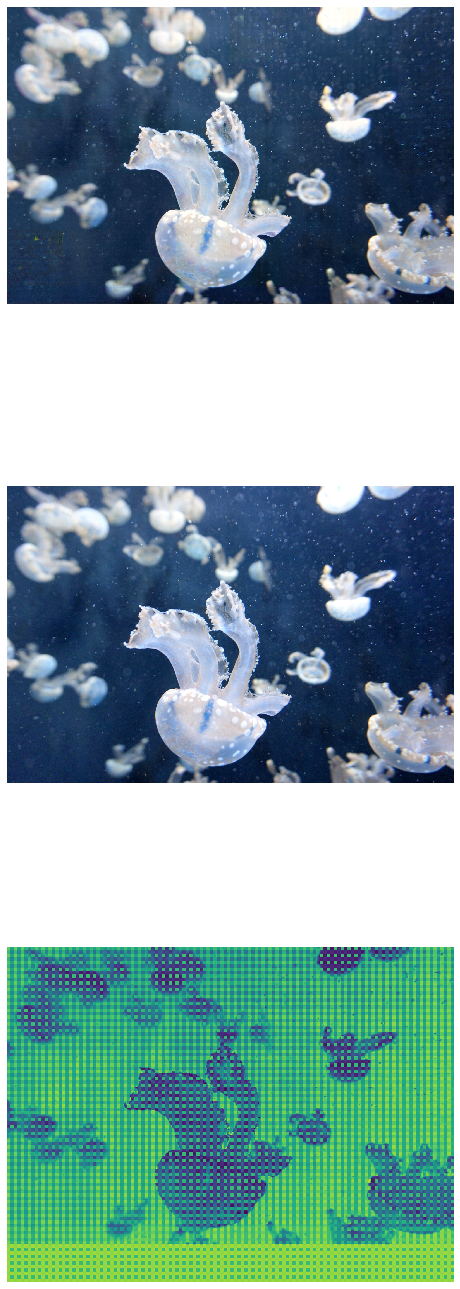

In [11]:
plt.figure(figsize=(8, 25))
plt.subplot(3, 1, 1)
plt.imshow(Iout)
plt.axis('off')
plt.subplot(3, 1, 2)
plt.imshow(I)
plt.axis('off')
plt.subplot(3, 1, 3)
plt.imshow(Enout)
plt.axis('off')

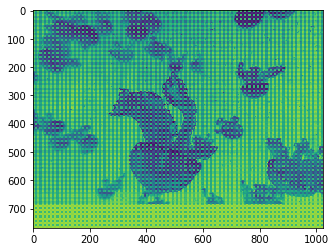

In [12]:
plt.imshow(Enout)